<a href="https://colab.research.google.com/github/nschultze/CS579Project2/blob/main/annual_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
df_dict = {}
have_samples = True ## set true if already have samples from dataset
have_graphs = True ## set to false if not have graph files locally

years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

In [8]:
## stores each df/annual data in the dictionary to be referenced easily, quickly, and iteratively as needed

if not have_samples:
  for y in years:
    print(f'Reading in and sampling {y} data')
    df_dict[y] = pd.read_csv(f'/content/drive/MyDrive/CS579 Dataset/Taxi_Trips_{y}.csv').sample(n=1000000, replace=False, random_state=12357)
    print(len(df_dict[y]))

    # download sample
    download_path = f'/content/drive/MyDrive/CS579 Dataset/Taxi_Trips_{y}_Sample.csv'
    print(f'Downloading df as csv to {download_path}')
    df_dict[y].to_csv(download_path, index=False)

elif not have_graphs:
  ## read in the sampled data
  for y in years:
    print(f'Reading in and sampling {y} data')
    df_dict[y] = pd.read_csv(f'/content/drive/MyDrive/CS579 Dataset/Taxi_Trips_{y}.csv')
    print(len(df_dict[y]))

Reading in and sampling 2013 data
1000000
Reading in and sampling 2014 data
1000000
Reading in and sampling 2015 data
1000000
Reading in and sampling 2016 data
1000000
Reading in and sampling 2017 data
1000000
Reading in and sampling 2018 data
1000000
Reading in and sampling 2019 data
1000000
Reading in and sampling 2020 data
1000000
Reading in and sampling 2021 data
1000000
Reading in and sampling 2022 data
1000000
Reading in and sampling 2023 data
1000000


In [15]:
print(df_dict['2013'])

            Trip Start Timestamp  Trip Miles  Pickup Community Area  \
9898842   08/08/2013 10:00:00 AM        0.55                     32   
727213    11/04/2013 01:30:00 PM        3.10                      8   
8231100   04/09/2013 05:00:00 AM        2.20                     60   
7769534   04/08/2013 07:45:00 PM       17.70                      8   
9385046   09/08/2013 12:15:00 AM        2.50                      8   
...                          ...         ...                    ...   
4733073   11/16/2013 04:15:00 PM        0.50                      8   
10208357  11/03/2013 07:15:00 PM        0.14                      8   
4106967   07/01/2013 12:45:00 AM        2.70                     16   
10227383  10/17/2013 03:15:00 PM        0.21                     32   
3001448   03/16/2013 01:45:00 PM        0.20                      8   

          Dropoff Community Area  
9898842                        8  
727213                        33  
8231100                       61  
7769534

In [19]:
## create graph
def gen_graph(df):
  # Create a directed graph from df
  G = nx.DiGraph()

  ## 1 mil rows in about 1 min 9 seconds
  ## 4 mil in 4.5 mins
  ## 12.4 mil in 14 mins 8 sec

  for index, row in df.iterrows():
    from_community = row['Pickup Community Area']
    to_community = row['Dropoff Community Area']

    if G.has_edge(from_community, to_community):
        # Increment the weight of the existing edge by 1
        G[from_community][to_community]['weight'] += 1
    else:
        # Add a new edge with weight 1
        G.add_edge(from_community, to_community, weight=1)

  return G

In [25]:
graph_dict = {}

## takes about 1.1 mins per graph - so 11 mins total
if not have_graphs:
  for y in years:
    print(f'Developing graph for {y}')
    graph_dict[y] = gen_graph(df_dict[y])
    nx.write_graphml(graph_dict[y], f"'/content/drive/MyDrive/CS579 Dataset/graph_{y}.graphml")

## read in the graphs if we have them downloaded already
else:
  for y in years:
    graph_dict[y] = nx.read_graphml(f"/content/drive/MyDrive/CS579 Dataset/graph_{y}.graphml")

In [22]:
#for y in years:
#  nx.write_graphml(graph_dict[y], f"/content/drive/MyDrive/CS579 Dataset/graph_{y}.graphml")

In [38]:
def get_degree_graph(G, year):
    # Calculate in-degrees and out-degrees
    in_degrees = dict(G.in_degree(weight='weight'))
    out_degrees = dict(G.out_degree(weight='weight'))

    # Sort nodes by out-degree (highest to lowest)
    sorted_nodes = sorted(G.nodes(), key=lambda x: out_degrees[x], reverse=True)

    # Plot
    plt.figure(figsize=(12, 8))
    bar_width = 0.35
    index = range(len(sorted_nodes))

    plt.bar(index, [in_degrees[node] for node in sorted_nodes], bar_width, label='In-degree')
    plt.bar([i + bar_width for i in index], [out_degrees[node] for node in sorted_nodes], bar_width, label='Out-degree')

    plt.xlabel('Node')
    plt.ylabel('Degree')
    plt.title(f'In-degree and Out-degree of Communities in {year}')
    plt.xticks([i + bar_width / 2 for i in index], sorted_nodes, rotation='vertical')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plotted in and out degree for each year

### sorted by out-degree

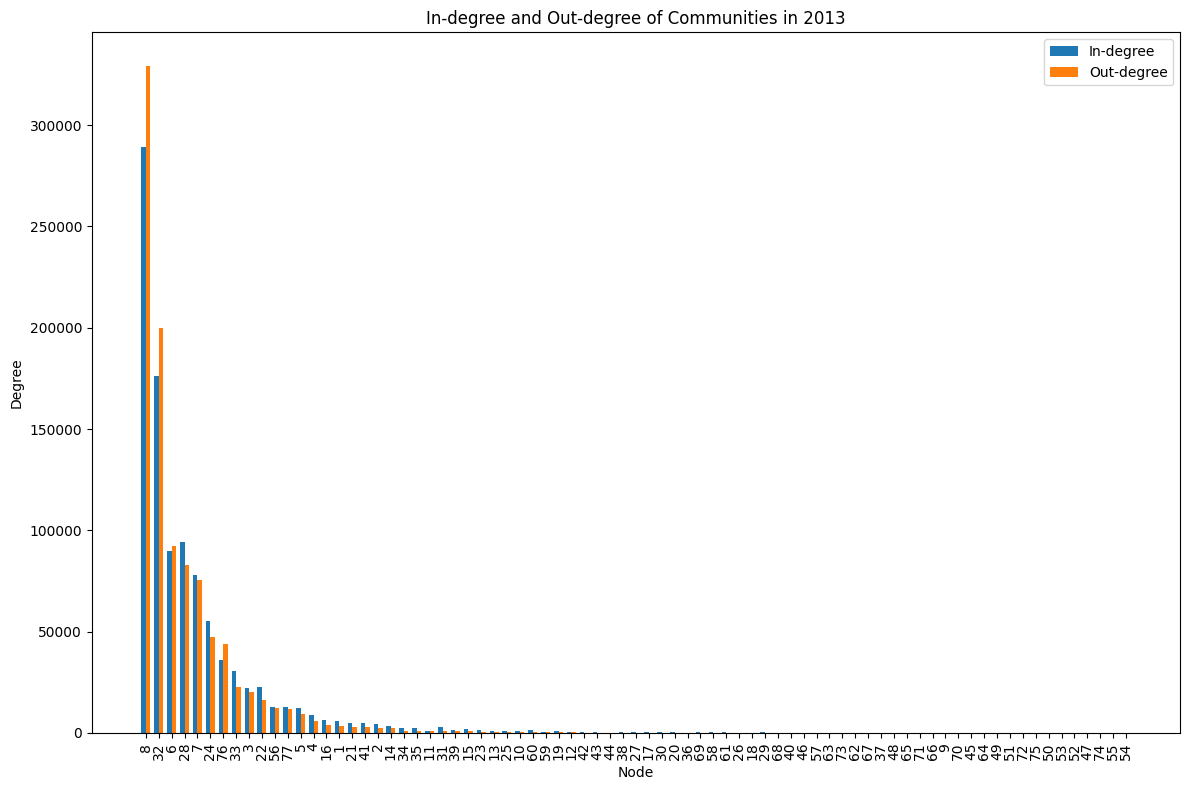

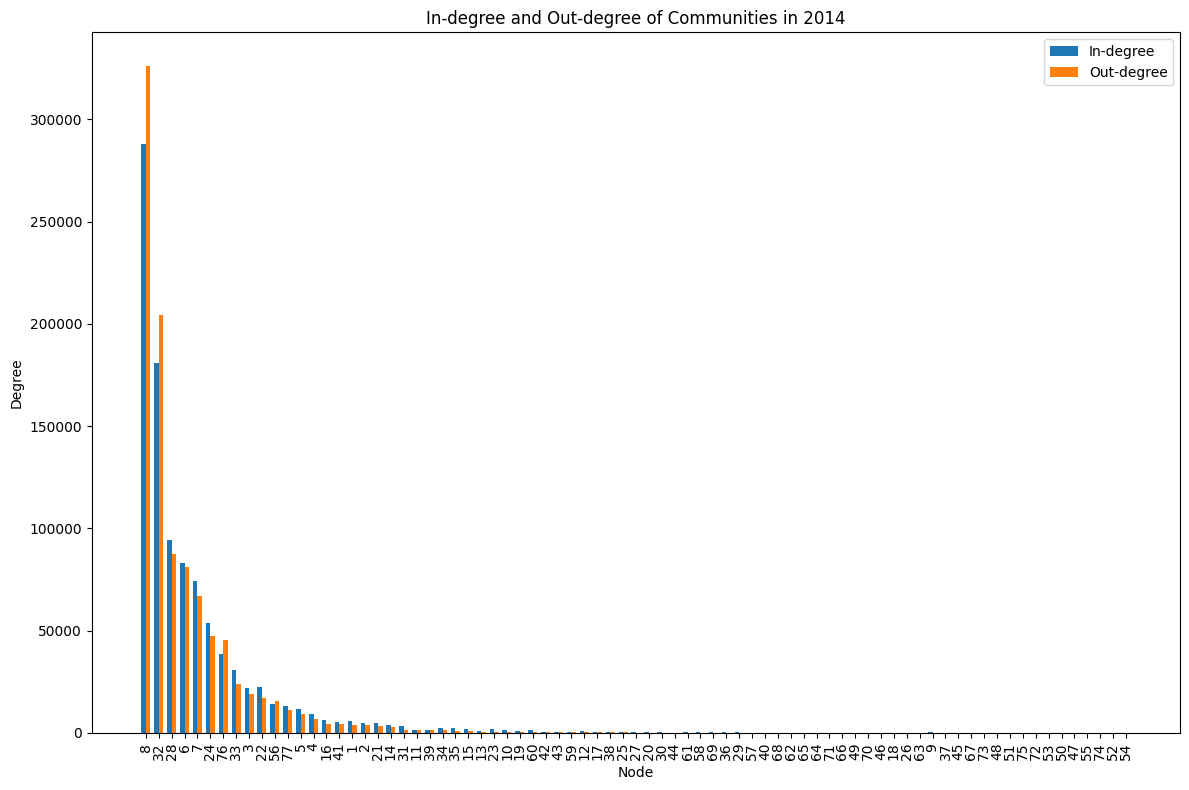

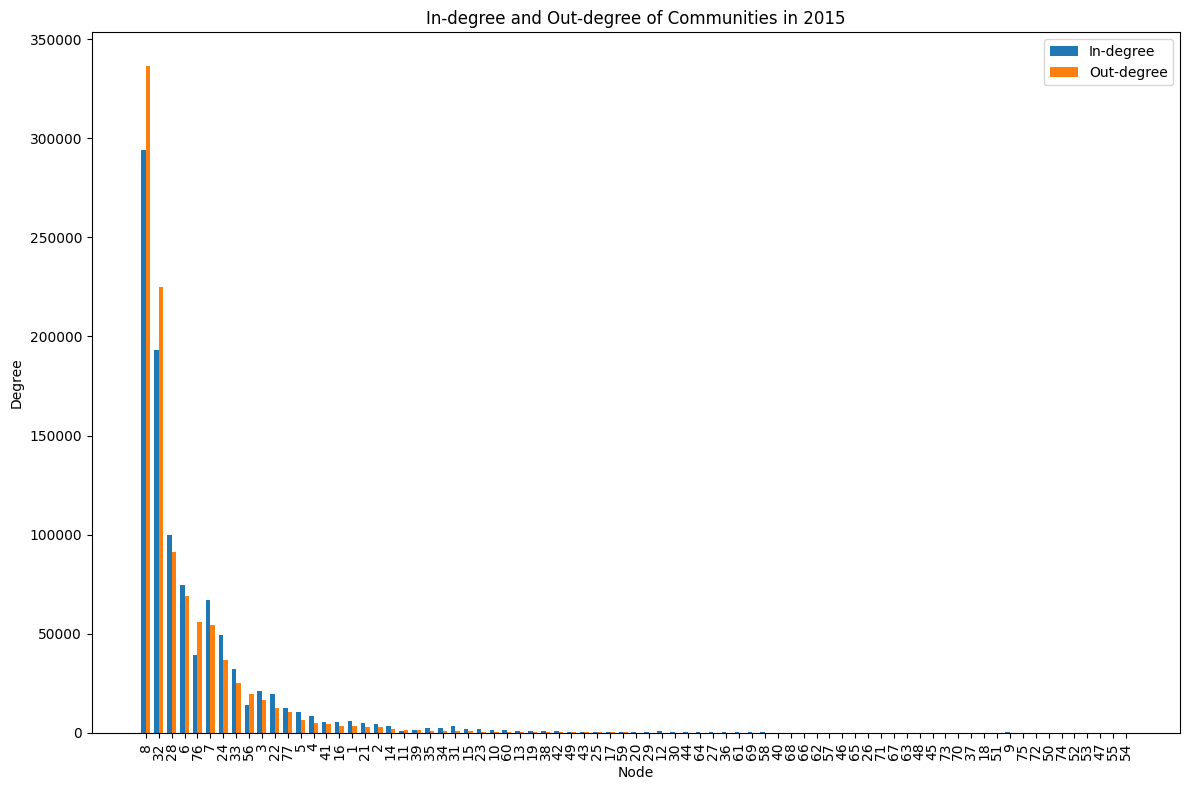

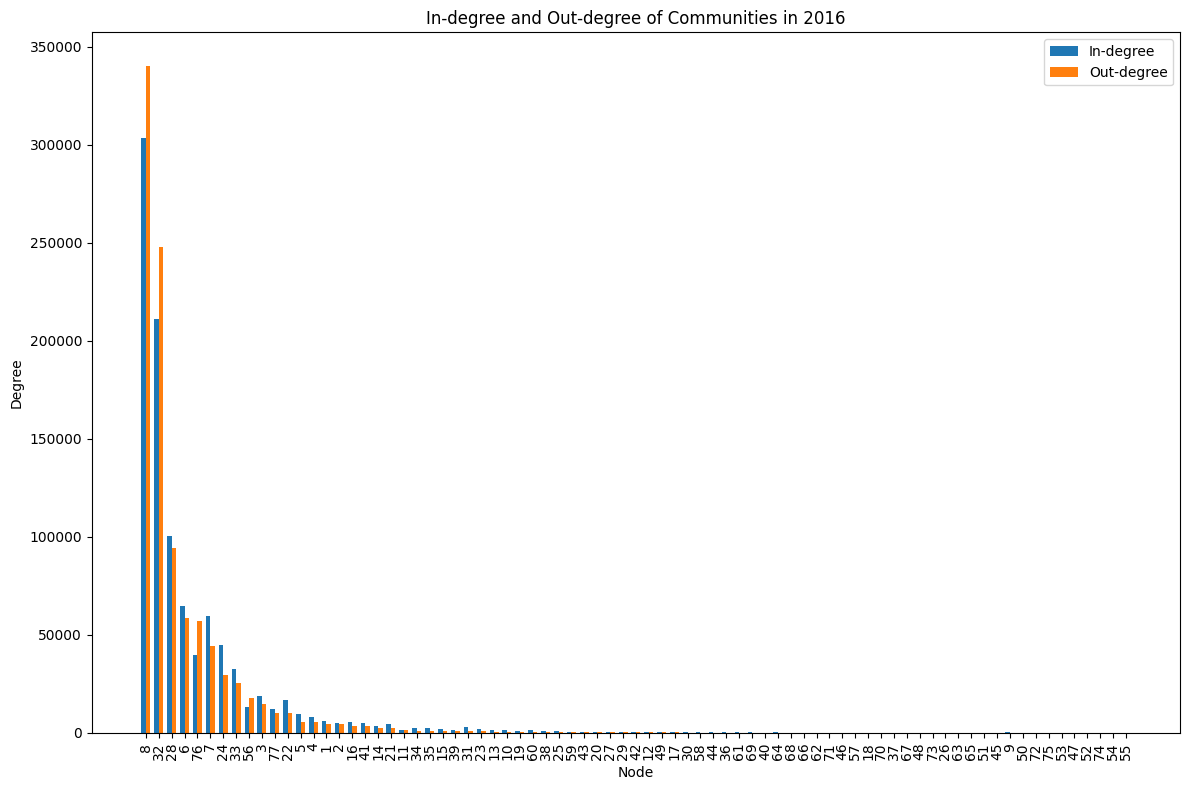

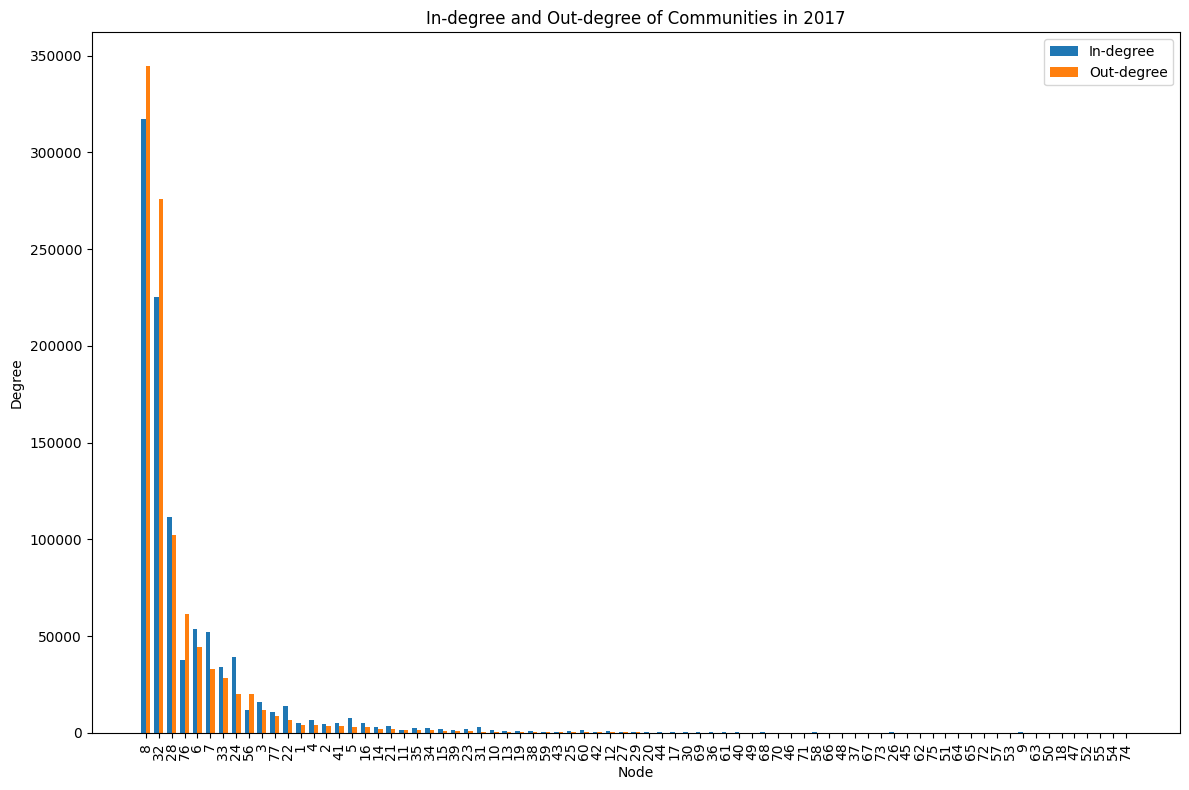

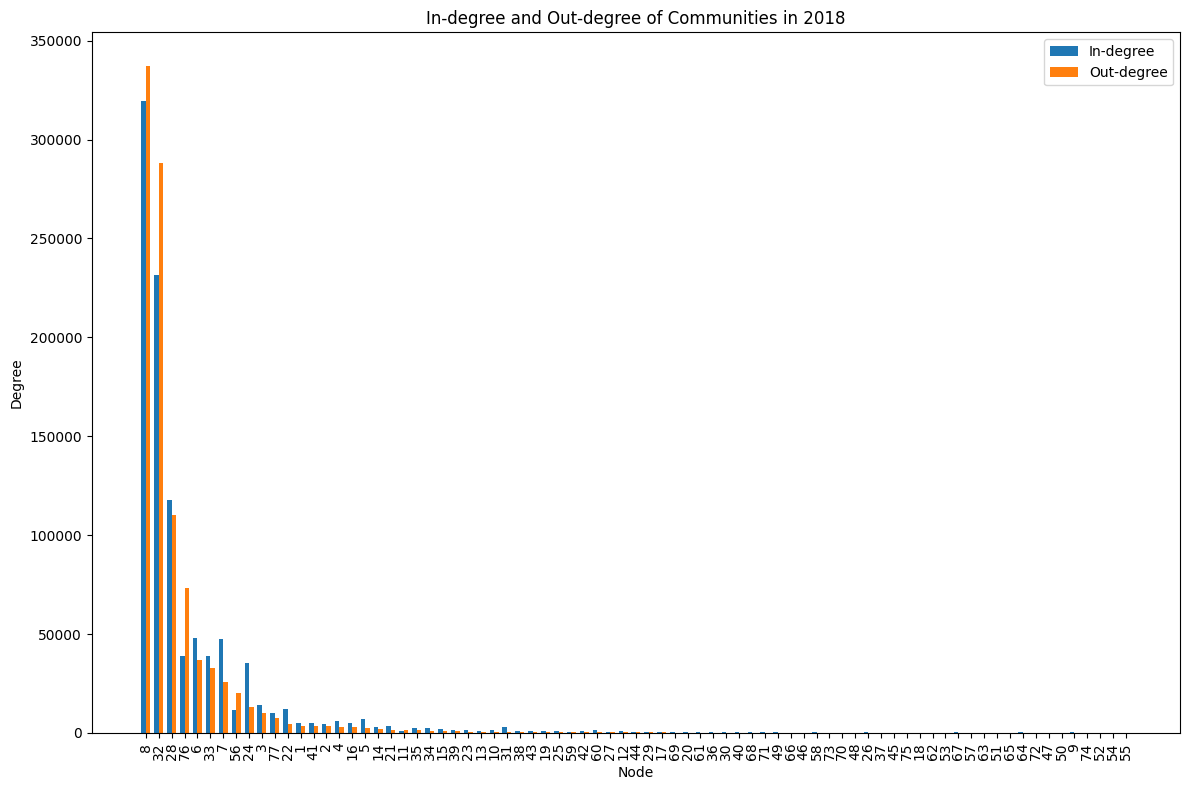

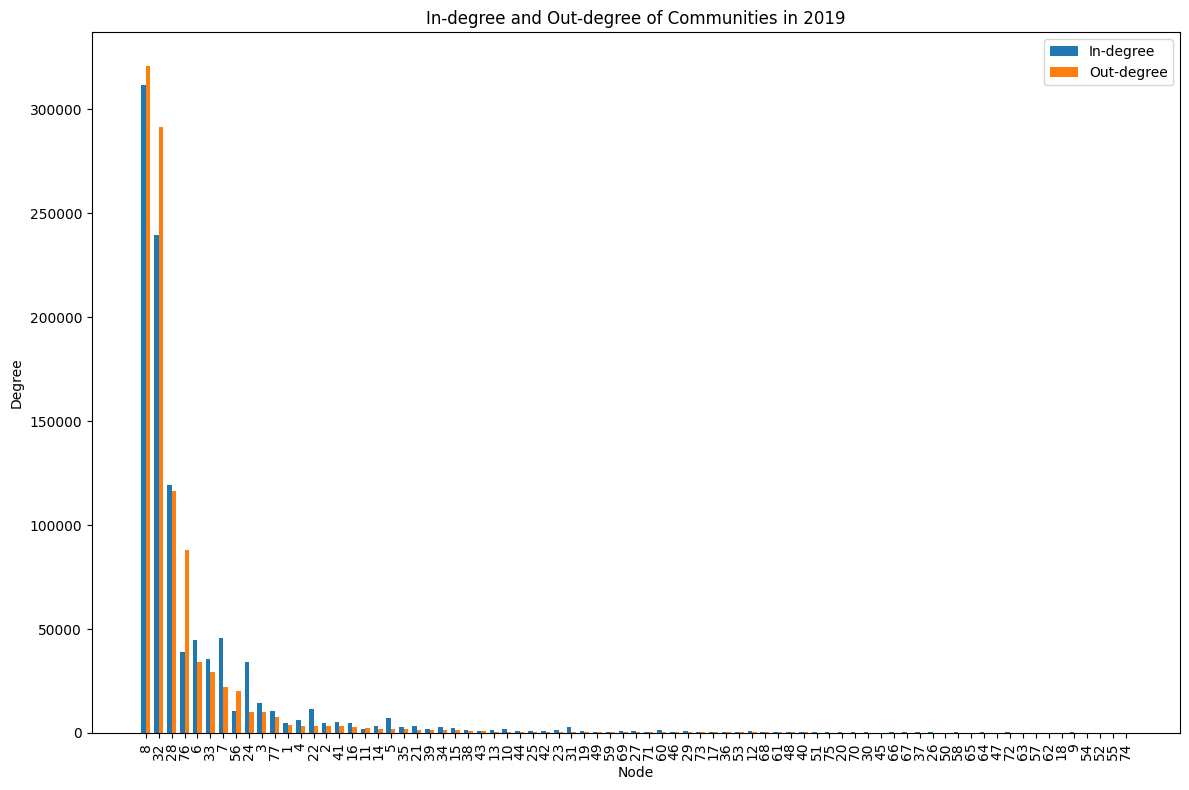

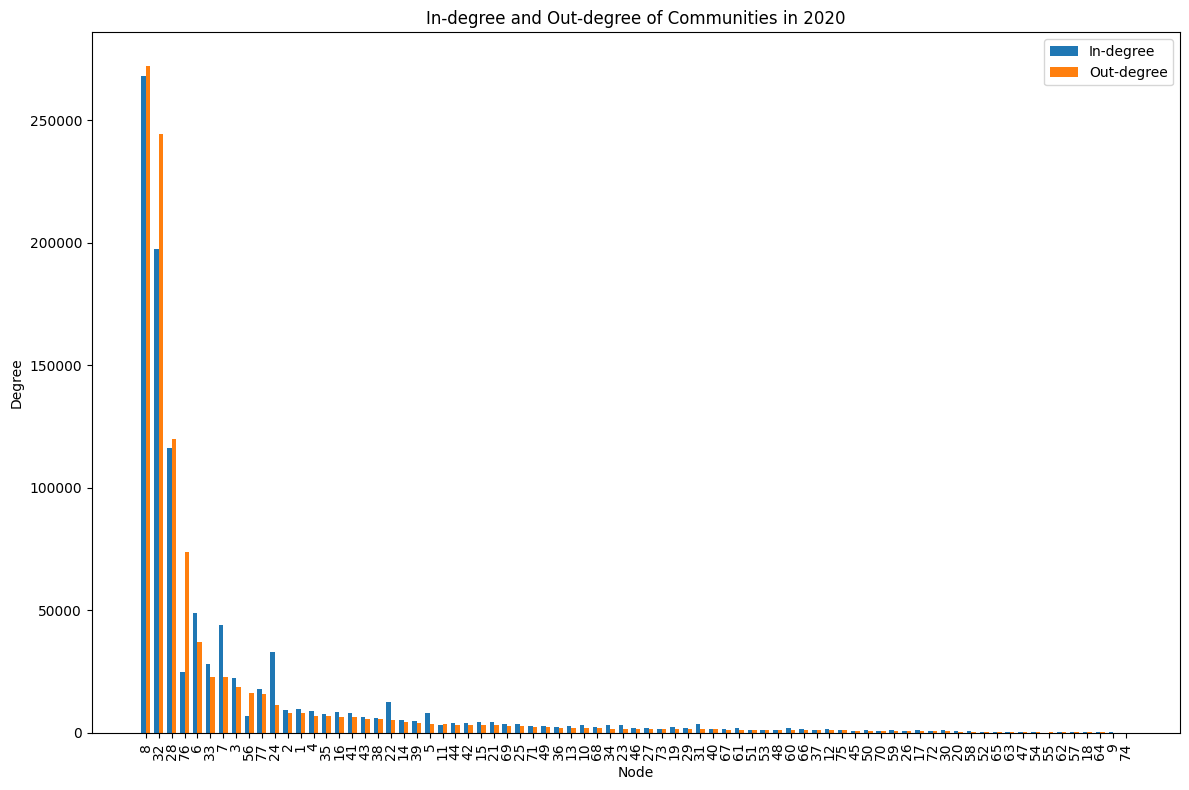

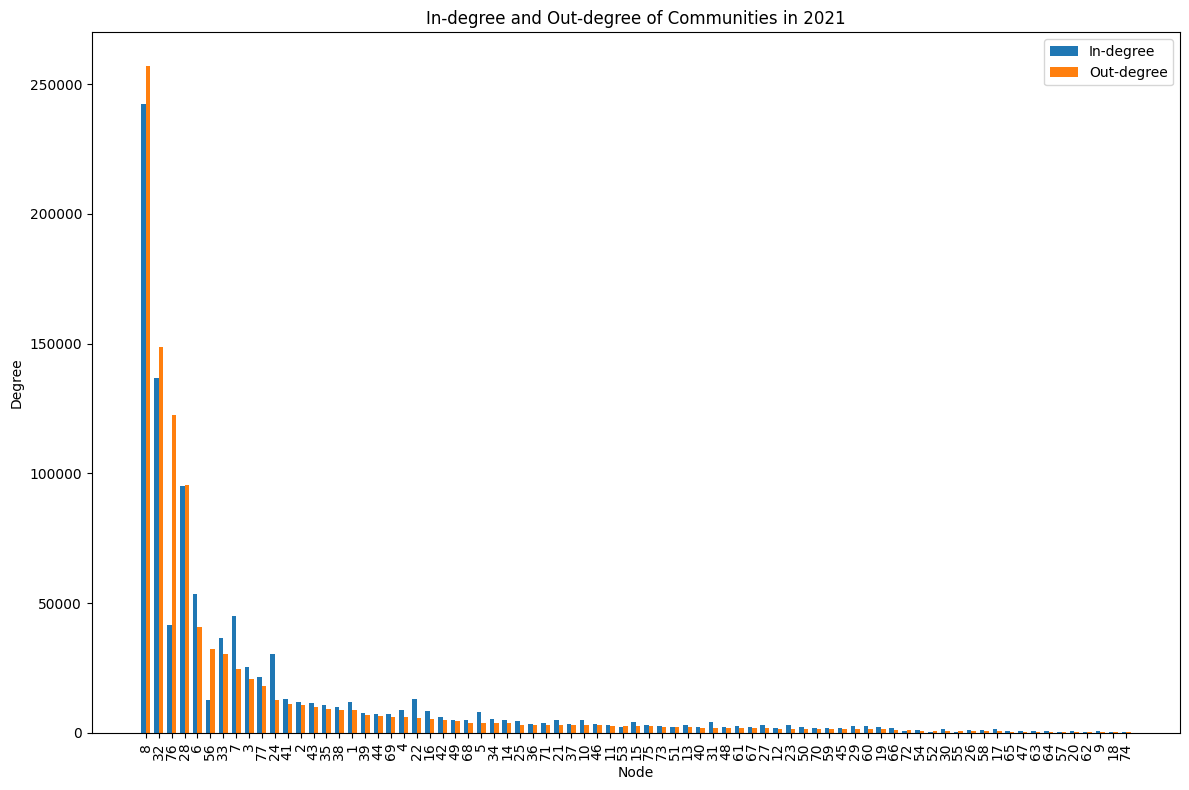

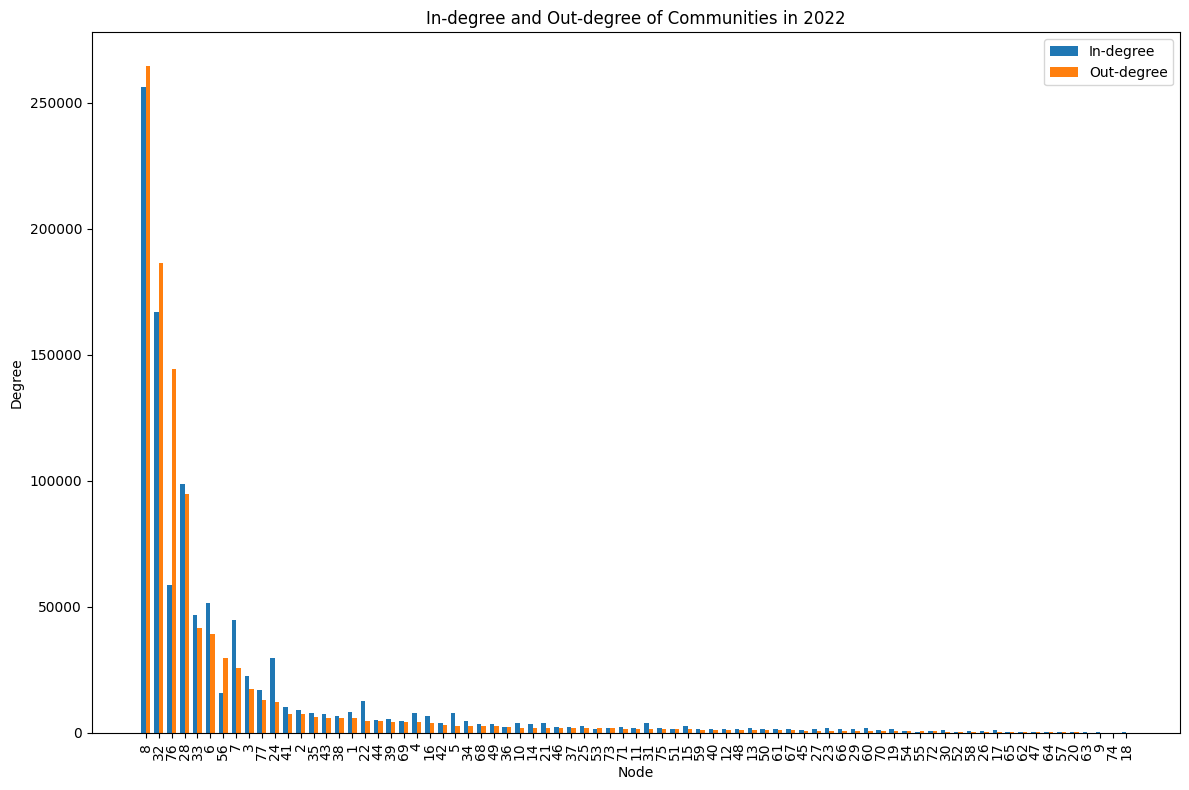

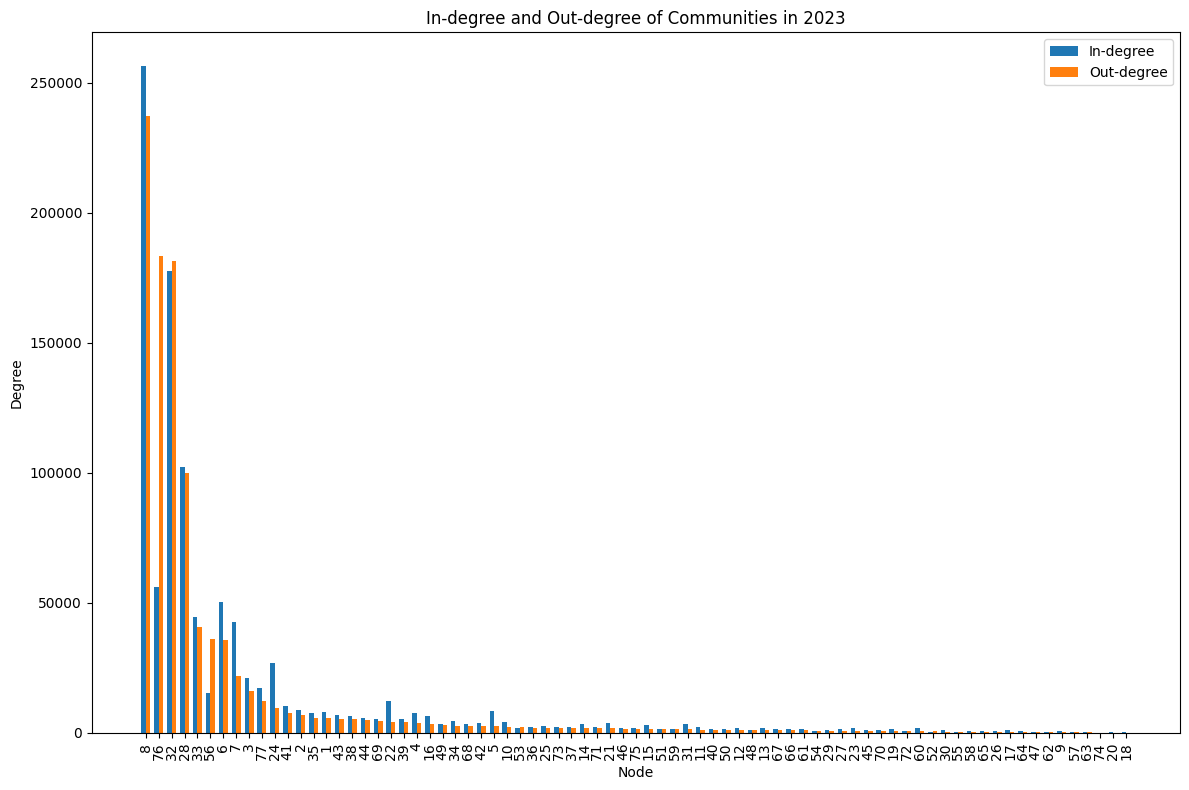

In [39]:
for y in years:
  get_degree_graph(graph_dict[y], y)

# Edge betweenness centrality

In [74]:
#### func to return top n betwneeness centralities
### Note in the way we defined edges and weights a high
### value here meets it is NOT an important edge for the network as it is not a short path
### (ie) nodes with few trips = short path by edge weight = high betweeness centrality

def get_edge_betweeness(G, year, n):
  # edge betweenness centrality
  edge_betweenness = nx.edge_betweenness_centrality(graph_dict[year], weight='weight')

  # sort the edge betweenness centrality in desc order
  sorted_edge_betweenness = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)

  # return top n edge betweenness for given year
  print(f"\n{year} Top {n} Edge Betweenness Centralities - Paths with least taxi traffic:")
  print('         (From, To)')
  for i, (edge, centrality) in enumerate(sorted_edge_betweenness[:n], 1):
    print(f"{i}. Edge: {edge}, Betweenness Centrality: {centrality}")
  return sorted_edge_betweenness[:n]

In [88]:
edge_btw_dict = {}

for y in years:
  edge_btw_dict[y] = get_edge_betweeness(graph_dict[y], y, 20)


2013 Top 20 Edge Betweenness Centralities - Paths with least taxi traffic:
         (From, To)
1. Edge: ('47', '41'), Betweenness Centrality: 0.017927046012068862
2. Edge: ('32', '47'), Betweenness Centrality: 0.015742023229189765
3. Edge: ('47', '46'), Betweenness Centrality: 0.015287310979087355
4. Edge: ('74', '8'), Betweenness Centrality: 0.013953611747729397
5. Edge: ('41', '11'), Betweenness Centrality: 0.011904903903195397
6. Edge: ('28', '47'), Betweenness Centrality: 0.011173155597141262
7. Edge: ('46', '25'), Betweenness Centrality: 0.010369219730694313
8. Edge: ('53', '38'), Betweenness Centrality: 0.00984482259802864
9. Edge: ('33', '57'), Betweenness Centrality: 0.009679088662045567
10. Edge: ('52', '30'), Betweenness Centrality: 0.009571261079647805
11. Edge: ('55', '48'), Betweenness Centrality: 0.00956691573714637
12. Edge: ('54', '30'), Betweenness Centrality: 0.009251825603374597
13. Edge: ('8', '50'), Betweenness Centrality: 0.009241772066102131
14. Edge: ('50', '2'

In [93]:
print([r for r in edge_btw_dict.values()])

[[(('47', '41'), 0.017927046012068862), (('32', '47'), 0.015742023229189765), (('47', '46'), 0.015287310979087355), (('74', '8'), 0.013953611747729397), (('41', '11'), 0.011904903903195397), (('28', '47'), 0.011173155597141262), (('46', '25'), 0.010369219730694313), (('53', '38'), 0.00984482259802864), (('33', '57'), 0.009679088662045567), (('52', '30'), 0.009571261079647805), (('55', '48'), 0.00956691573714637), (('54', '30'), 0.009251825603374597), (('8', '50'), 0.009241772066102131), (('50', '2'), 0.009216600942889832), (('48', '30'), 0.009197533470885219), (('8', '52'), 0.00894281773895581), (('70', '64'), 0.00876566992799119), (('56', '26'), 0.008541435138967487), (('66', '30'), 0.008046391551835223), (('56', '54'), 0.007883011174118286)], [(('54', '66'), 0.025007085885671528), (('32', '55'), 0.016747757654600123), (('8', '54'), 0.014988403836233639), (('55', '48'), 0.013301298789126509), (('52', '46'), 0.012855120822178207), (('28', '50'), 0.011268499894772672), (('74', '49'), 0.

In [91]:
print((edge_btw_dict))

{'2013': [(('47', '41'), 0.017927046012068862), (('32', '47'), 0.015742023229189765), (('47', '46'), 0.015287310979087355), (('74', '8'), 0.013953611747729397), (('41', '11'), 0.011904903903195397), (('28', '47'), 0.011173155597141262), (('46', '25'), 0.010369219730694313), (('53', '38'), 0.00984482259802864), (('33', '57'), 0.009679088662045567), (('52', '30'), 0.009571261079647805), (('55', '48'), 0.00956691573714637), (('54', '30'), 0.009251825603374597), (('8', '50'), 0.009241772066102131), (('50', '2'), 0.009216600942889832), (('48', '30'), 0.009197533470885219), (('8', '52'), 0.00894281773895581), (('70', '64'), 0.00876566992799119), (('56', '26'), 0.008541435138967487), (('66', '30'), 0.008046391551835223), (('56', '54'), 0.007883011174118286)], '2014': [(('54', '66'), 0.025007085885671528), (('32', '55'), 0.016747757654600123), (('8', '54'), 0.014988403836233639), (('55', '48'), 0.013301298789126509), (('52', '46'), 0.012855120822178207), (('28', '50'), 0.011268499894772672), (

In [97]:
common_unpopular_edges = set()
for l in edge_btw_dict.values():
  #print(l)
  for v in l:
    #print(v[0])
    common_unpopular_edges.add(v[0])
  #  v[0] ## pulls out tuple


In [106]:
#for e in common_unpopular_edges:
  #print(e)

In [110]:
unpopular_edges_count = {}
for l in edge_btw_dict.values():
  #print(l)
  for v in l:
    #print(v[0])
    unpopular_edges_count[v[0]] = unpopular_edges_count.get(v[0], 0) + 1
    #common_unpopular_edges.add(v[0])
  #  v[0] ## pulls out tuple


### Prints the n unpopular paths along with their frequency occuring over the 10 year period

In [111]:
# Sort the dictionary by values in descending order
sorted_dict = sorted(unpopular_edges_count.items(), key=lambda x: x[1], reverse=True)

for key, value in sorted_dict:
    print(f"{key}: {value}")

('8', '55'): 4
('28', '74'): 4
('74', '8'): 3
('55', '48'): 3
('32', '55'): 3
('8', '54'): 3
('56', '47'): 3
('76', '54'): 3
('32', '74'): 3
('76', '47'): 3
('74', '28'): 3
('47', '41'): 2
('32', '47'): 2
('47', '46'): 2
('28', '47'): 2
('54', '66'): 2
('28', '50'): 2
('55', '33'): 2
('46', '29'): 2
('47', '44'): 2
('48', '61'): 2
('54', '49'): 2
('1', '17'): 2
('54', '70'): 2
('33', '20'): 2
('56', '18'): 2
('8', '74'): 2
('56', '55'): 2
('56', '9'): 2
('24', '52'): 2
('24', '72'): 2
('9', '32'): 2
('41', '11'): 1
('46', '25'): 1
('53', '38'): 1
('33', '57'): 1
('52', '30'): 1
('54', '30'): 1
('8', '50'): 1
('50', '2'): 1
('48', '30'): 1
('8', '52'): 1
('70', '64'): 1
('56', '26'): 1
('66', '30'): 1
('56', '54'): 1
('52', '46'): 1
('74', '49'): 1
('50', '71'): 1
('29', '11'): 1
('50', '27'): 1
('47', '45'): 1
('74', '41'): 1
('44', '30'): 1
('50', '51'): 1
('76', '71'): 1
('55', '46'): 1
('54', '32'): 1
('47', '3'): 1
('50', '29'): 1
('76', '49'): 1
('38', '11'): 1
('50', '49'): 1
('4

# Community Detection with Louvian Method

https://python-louvain.readthedocs.io/en/latest/

In [68]:
!pip install python-louvain

In [116]:
from networkx.algorithms import community

In [117]:
### returns the communities for a given graph using Louvain Method
def get_communities(G, y):
  louvain_communities = community.greedy_modularity_communities(G)
  print(f"\nLouvain Method Communities for {y}:")
  for i, community_set in enumerate(louvain_communities, 1):
    print(f"Community {i}: {list(community_set)}")

In [118]:
for y in years:
  get_communities(graph_dict[y], y)


Louvain Method Communities for 2013:
Community 1: ['40', '33', '65', '44', '53', '8', '39', '38', '35', '37', '52', '62', '63', '45', '72', '56', '51', '31', '75', '66', '58', '55', '60', '59', '71', '41', '68', '47', '61', '70', '73', '42', '50', '28', '48', '69', '46', '32', '43', '36', '30', '34', '49', '54', '67']
Community 2: ['12', '76', '24', '25', '16', '15', '20', '23', '22', '17', '5', '27', '57', '6', '21', '11', '1', '29', '19', '26', '18', '3', '10', '9', '7', '2', '4', '77', '14', '13']
Community 3: ['64']
Community 4: ['74']

Louvain Method Communities for 2014:
Community 1: ['40', '33', '44', '53', '8', '39', '38', '37', '35', '52', '72', '56', '45', '51', '75', '66', '55', '41', '71', '68', '61', '70', '47', '73', '42', '50', '28', '48', '69', '46', '32', '74', '43', '36', '34', '49', '54', '67']
Community 2: ['12', '25', '24', '16', '15', '23', '20', '22', '27', '5', '17', '6', '21', '11', '1', '29', '19', '26', '30', '18', '3', '9', '10', '7', '2', '4', '77', '14', 

# Now let's analyze communities - based on season of the year

In [121]:
all_data_df = pd.concat(df_dict.values(), ignore_index=True)
print(all_data_df)

            Trip Start Timestamp  Trip Miles  Pickup Community Area  \
0         08/08/2013 10:00:00 AM        0.55                     32   
1         11/04/2013 01:30:00 PM        3.10                      8   
2         04/09/2013 05:00:00 AM        2.20                     60   
3         04/08/2013 07:45:00 PM       17.70                      8   
4         09/08/2013 12:15:00 AM        2.50                      8   
...                          ...         ...                    ...   
10999995  04/27/2023 12:45:00 PM        0.60                      8   
10999996  03/21/2023 12:00:00 PM        0.88                      8   
10999997  01/31/2023 05:30:00 PM        0.10                     32   
10999998  06/03/2023 12:45:00 PM        4.70                     53   
10999999  02/22/2023 11:45:00 AM       12.63                     32   

          Dropoff Community Area  
0                              8  
1                             33  
2                             61  
3      

In [122]:
all_data_df['Trip Start Timestamp'] = pd.to_datetime(all_data_df['Trip Start Timestamp'], format='%m/%d/%Y %I:%M:%S %p')

winter_range = ((all_data_df['Trip Start Timestamp'].dt.month >= 11) | (all_data_df['Trip Start Timestamp'].dt.month <= 3))
not_winter_range = ~winter_range

In [126]:
winter_df = all_data_df[winter_range]
not_winter_df = all_data_df[not_winter_range]

In [124]:
print(winter_df)

         Trip Start Timestamp  Trip Miles  Pickup Community Area  \
1         2013-11-04 13:30:00        3.10                      8   
6         2013-12-16 01:00:00        2.90                     24   
11        2013-01-29 08:00:00        0.50                      8   
12        2013-03-28 18:30:00        3.00                      8   
13        2013-11-08 11:30:00        0.30                      3   
...                       ...         ...                    ...   
10999989  2023-12-20 20:45:00       15.32                     76   
10999992  2023-12-01 15:30:00        1.40                     32   
10999996  2023-03-21 12:00:00        0.88                      8   
10999997  2023-01-31 17:30:00        0.10                     32   
10999999  2023-02-22 11:45:00       12.63                     32   

          Dropoff Community Area  
1                             33  
6                              7  
11                            28  
12                            24  
13      

In [127]:
print(not_winter_df)

         Trip Start Timestamp  Trip Miles  Pickup Community Area  \
0         2013-08-08 10:00:00        0.55                     32   
2         2013-04-09 05:00:00        2.20                     60   
3         2013-04-08 19:45:00       17.70                      8   
4         2013-09-08 00:15:00        2.50                      8   
5         2013-06-06 06:00:00        1.10                      8   
...                       ...         ...                    ...   
10999991  2023-10-14 20:00:00        1.00                      8   
10999993  2023-06-02 21:30:00        2.86                      7   
10999994  2023-04-06 11:45:00        1.41                     32   
10999995  2023-04-27 12:45:00        0.60                      8   
10999998  2023-06-03 12:45:00        4.70                     53   

          Dropoff Community Area  
0                              8  
2                             61  
3                              8  
4                             24  
5       

In [138]:
try:
  winter_graph = nx.read_graphml(f"/content/drive/MyDrive/CS579 Dataset/graph_winter.graphml")
except FileNotFoundError:
  winter_graph = gen_graph(winter_df)
  nx.write_graphml(winter_graph, f"'/content/drive/MyDrive/CS579 Dataset/graph_winter.graphml")

In [137]:
try:
  not_winter_graph = nx.read_graphml(f"/content/drive/MyDrive/CS579 Dataset/graph_not_winter.graphml")
except FileNotFoundError:
  not_winter_graph = gen_graph(winter_df)
  nx.write_graphml(winter_graph, f"/content/drive/MyDrive/CS579 Dataset/graph_not_winter.graphml")

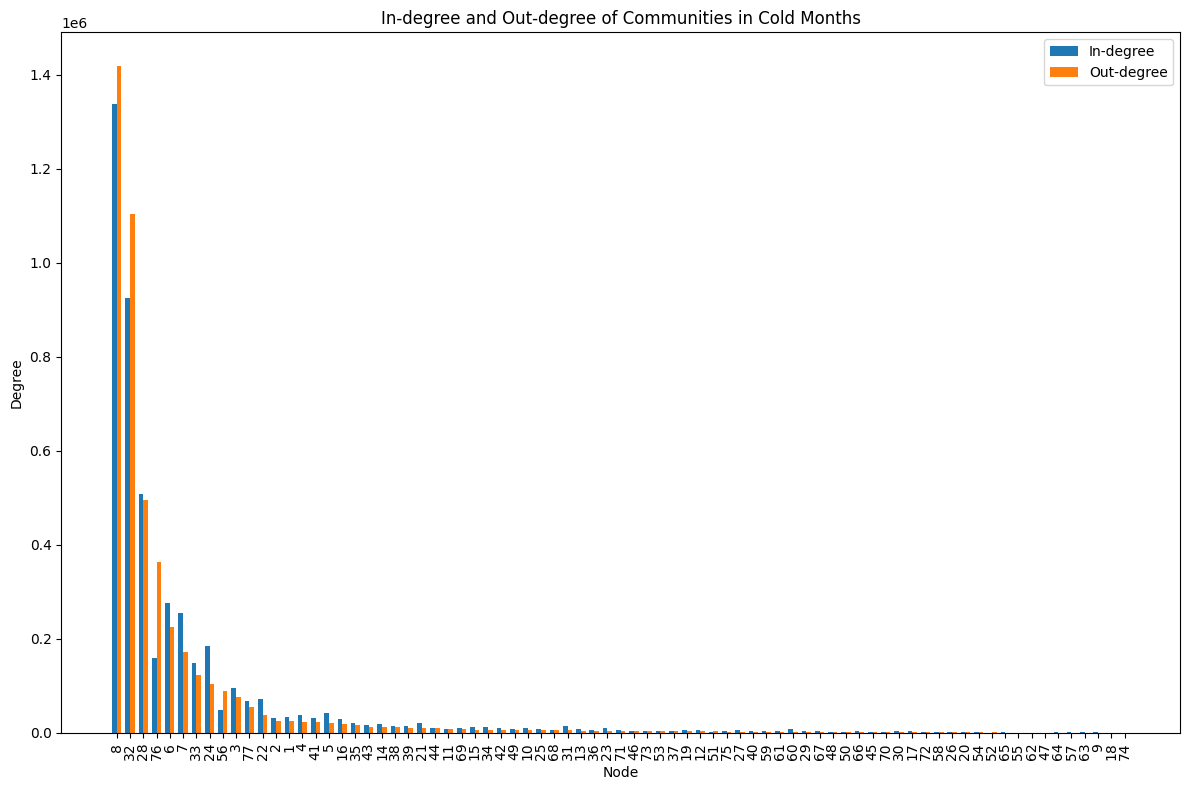

In [134]:
get_degree_graph(winter_graph, 'Cold Months')

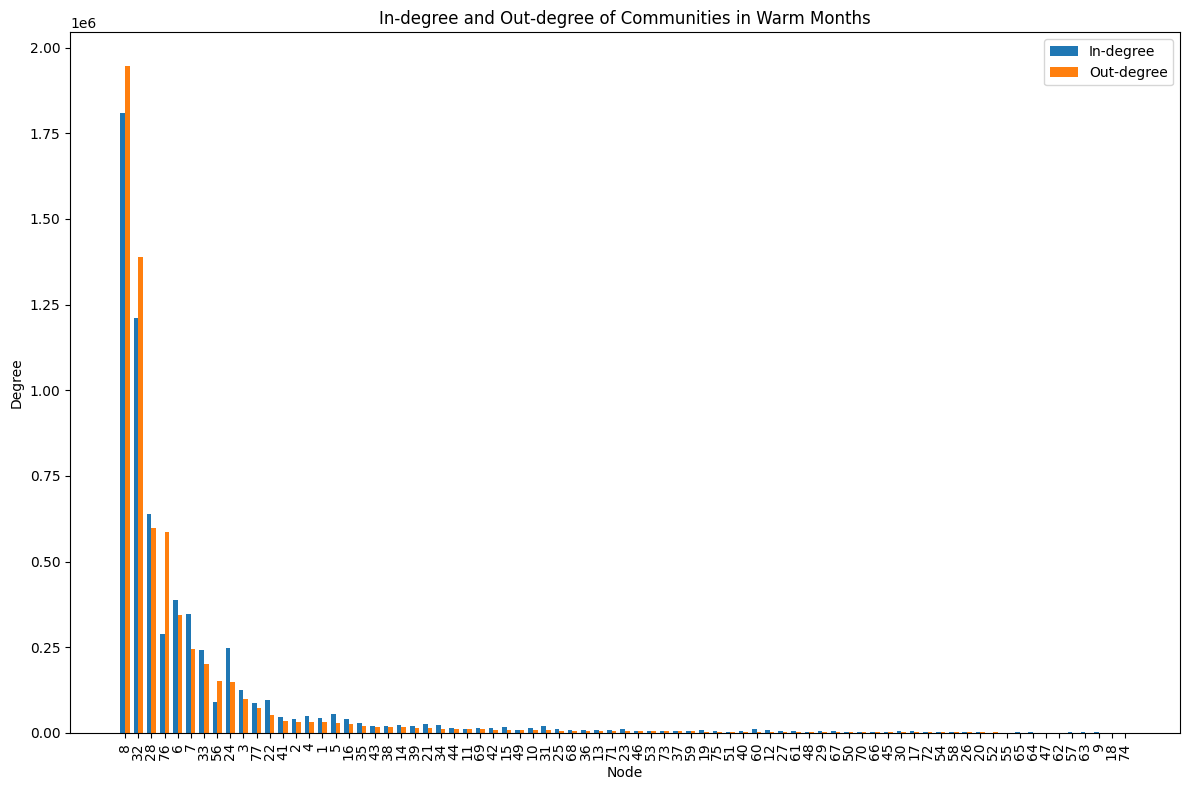

In [135]:
get_degree_graph(not_winter_graph, 'Warm Months')

## Community detection

In [139]:
get_communities(winter_graph, 'in Cold Months')

get_communities(not_winter_graph, 'in Warm Months')


Louvain Method Communities for in Cold Months:
Community 1: ['40', '65', '44', '53', '39', '38', '35', '37', '52', '62', '63', '72', '45', '51', '31', '75', '66', '60', '55', '41', '71', '68', '61', '47', '73', '70', '42', '50', '48', '69', '46', '74', '43', '64', '36', '34', '49', '67', '54']
Community 2: ['8', '76', '24', '22', '56', '27', '5', '17', '6', '10', '9', '2', '14', '13', '12', '25', '16', '15', '28', '23', '20', '21', '11', '1', '32', '29', '19', '26', '30', '18', '3', '7', '4', '77']
Community 3: ['59', '33', '58', '57']

Louvain Method Communities for in Warm Months:
Community 1: ['40', '65', '44', '53', '8', '39', '38', '37', '52', '63', '62', '56', '72', '45', '51', '31', '75', '66', '55', '41', '71', '68', '61', '70', '73', '47', '42', '50', '48', '69', '46', '74', '43', '49', '67', '54']
Community 2: ['33', '76', '24', '22', '27', '17', '5', '6', '10', '9', '2', '14', '13', '12', '25', '16', '15', '28', '23', '20', '21', '11', '1', '32', '29', '19', '26', '18', '3'

# Analysis of data combined over all years

In [140]:
try:
  full_graph = nx.read_graphml(f"/content/drive/MyDrive/CS579 Dataset/entire_sample_graph.graphml")
except FileNotFoundError:
  full_graph = gen_graph(all_data_df)
  nx.write_graphml(full_graph, f"/content/drive/MyDrive/CS579 Dataset/entire_sample_graph.graphml")

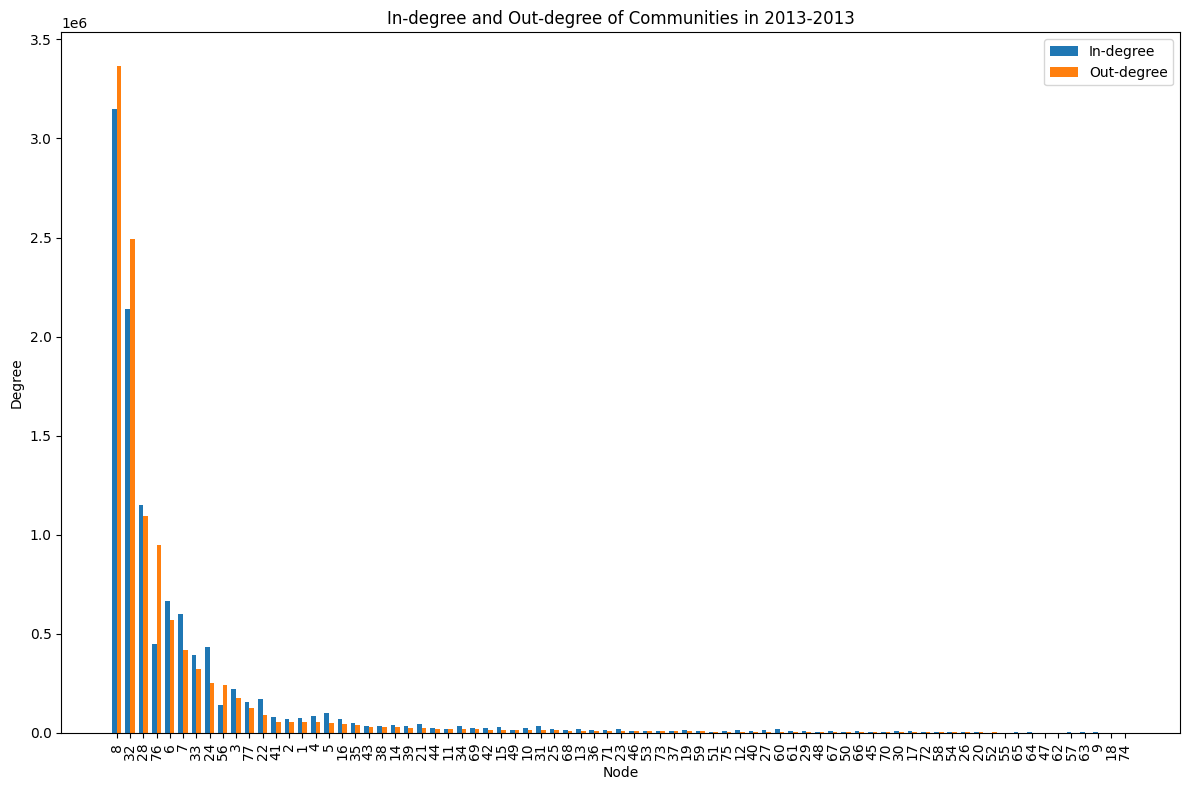

In [142]:
get_degree_graph(full_graph, '2013-2013')

In [144]:
get_communities(full_graph, '2013 - 2014')


Louvain Method Communities for 2013 - 2014:
Community 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 41, 56, 57, 64, 77]
Community 2: [31, 35, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


# Now let's analyze communities based on hour of the day